In [229]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def plot_temperature(start_date, days, use_existing_desired_temp=True, plot_servo_changes=True, title='Temperature and Servo State Variation Over Time'):
    # Read the indoor vent log CSV file into a DataFrame
    df_indoor = pd.read_csv('./vent_log.csv')
    df_indoor['Timestamp'] = pd.to_datetime(df_indoor['Timestamp'])  # Convert Timestamp column to datetime format

    # Filter the DataFrame based on the start date
    end_date = start_date + pd.Timedelta(days=days)  # Adjust the number of days as needed
    df_indoor = df_indoor[(df_indoor['Timestamp'] >= start_date) & (df_indoor['Timestamp'] <= end_date)]

    # Read the outdoor weather CSV file into a DataFrame
    df_outdoor = pd.read_csv('./apr_2024_waterloo_weather.csv')
    df_outdoor['Date/Time (LST)'] = pd.to_datetime(df_outdoor['Date/Time (LST)'])  # Convert Timestamp column to datetime format

    # Filter outdoor DataFrame to approximate start and end dates
    start_date_outdoor = min(df_outdoor['Date/Time (LST)'], key=lambda x: abs(x - start_date))
    end_date_outdoor = min(df_outdoor['Date/Time (LST)'], key=lambda x: abs(x - end_date))

    df_outdoor = df_outdoor[(df_outdoor['Date/Time (LST)'] >= start_date_outdoor) & (df_outdoor['Date/Time (LST)'] <= end_date_outdoor)]

    # Create a desired temperature column
    if use_existing_desired_temp:
        df_indoor['Desired Temperature'] = df_indoor['Desired Temperature']
    else:
        df_indoor['Desired Temperature'] = 20  # Set default desired temperature to 20°C
        df_indoor.loc[(df_indoor['Timestamp'].dt.hour >= 23) | (df_indoor['Timestamp'].dt.hour < 8), 'Desired Temperature'] = 17.5

    # Plot the temperature data
    plt.figure(figsize=(12, 8))
    gs = plt.GridSpec(2, 1, height_ratios=[2, 1])  # Define a grid with two rows, the second subplot's height is half of the first
    ax1 = plt.subplot(gs[0])
    ax1.plot(df_indoor['Timestamp'], df_indoor['Current Temperature'], label='Room Temperature')
    ax1.plot(df_outdoor['Date/Time (LST)'], df_outdoor['Temp (°C)'], label='Outdoor Temperature')
    ax1.plot(df_indoor['Timestamp'], df_indoor['Desired Temperature'], label='Desired Temperature', linestyle='--')
    ax1.set_ylabel('Temperature')
    ax1.set_title(f"Temperature Variation Over Time ({title})")
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(-5, 35)

    if plot_servo_changes:
        ax2 = plt.subplot(gs[1])
        ax2.plot(df_indoor['Timestamp'], df_indoor['Servo Close Percent'])
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Servo Close %')
        ax2.set_title('Servo Close % Over Time')
        ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Calculate Mean Absolute Error (MAE) between Current and Desired temperatures
    mae = mean_absolute_error(df_indoor['Current Temperature'], df_indoor['Desired Temperature'])
    print(title)
    print(f"Mean Absolute Error (MAE) between Current and Desired temperatures: {mae}")

    if plot_servo_changes:
      # Count the number of times servo close percent changes values
      servo_changes = (df_indoor['Servo Close Percent'].diff() != 0).sum()

      # Calculate the total number of days in the data
      total_days = (df_indoor['Timestamp'].max() - df_indoor['Timestamp'].min()).days + 1

      # Count the number of times servo close percent changes values
      servo_changes_per_day = servo_changes / total_days
      print(f"Number of times the servo moves per day: {servo_changes_per_day}")


## Baseline, Vent Not Installed

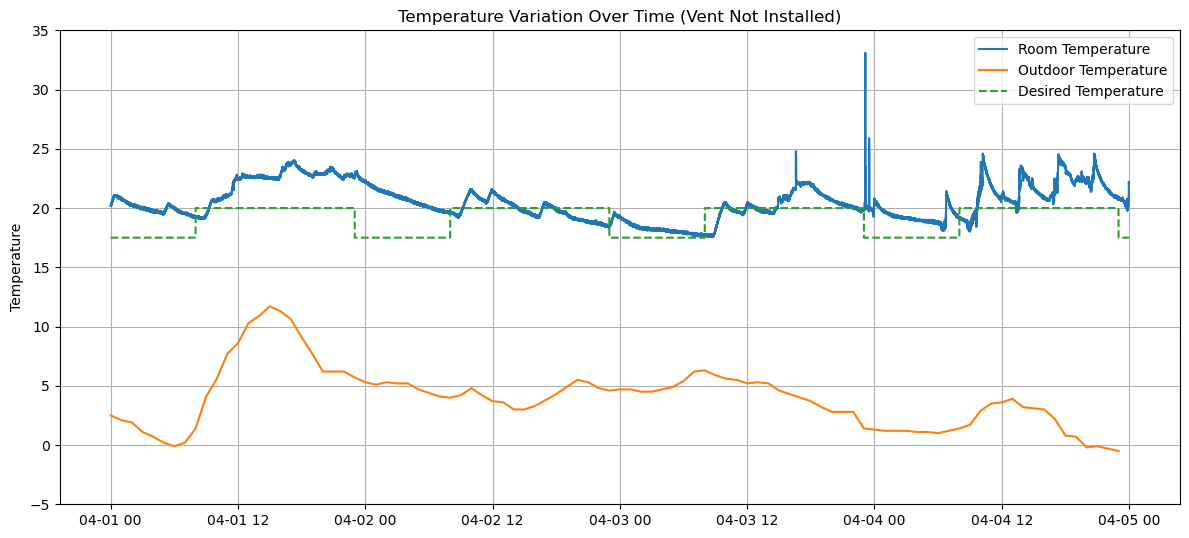

Vent Not Installed
Mean Absolute Error (MAE) between Current and Desired temperatures: 1.7074015988452786
Number of times the servo moves per day: 45.75


In [230]:
baseline_start_date = pd.Timestamp('2024-04-01 00:00:00')
plot_temperature(baseline_start_date, days=4, use_existing_desired_temp=False, title='Vent Not Installed', plot_servo_changes=False)

## Vent Installed, Bang-bang Controller

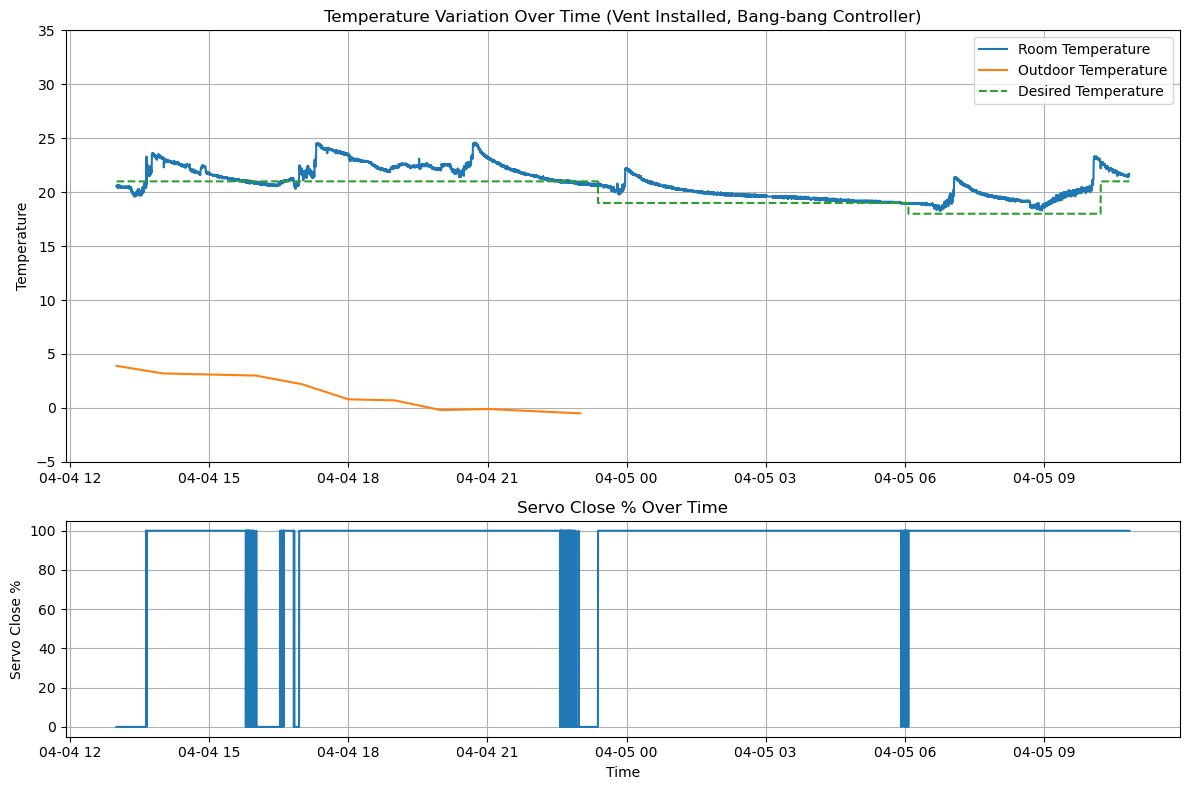

Vent Installed, Bang-bang Controller
Mean Absolute Error (MAE) between Current and Desired temperatures: 1.1329891898457425
Number of times the servo moves per day: 188.0


In [231]:
baseline_start_date = pd.Timestamp('2024-04-04 13:00:00')
plot_temperature(baseline_start_date, days=4, title='Vent Installed, Bang-bang Controller')

In [232]:
# if plot_servo_changes:
#     prev_value = None
#     for index, row in df_indoor.iterrows():
#         if prev_value is None:
#             prev_value = row['Servo Close Percent']
#         elif row['Servo Close Percent'] > prev_value:
#             # Servo has opened
#             plt.plot(row['Timestamp'], row['Current Temperature'], 'o', color='red', markersize=3, fillstyle='full')
#             prev_value = row['Servo Close Percent']
#         elif row['Servo Close Percent'] < prev_value:
#             # Servo has closed
#             plt.plot(row['Timestamp'], row['Current Temperature'], 'o', color='green', markersize=7, fillstyle='none')
#             prev_value = row['Servo Close Percent']